# This notebook produces all figures and experiments of the manuscript.

The initial two main-paper figures and the supplementary figure only need code from the vMFne package, or from dependencies stated in vMFne/requirements.txt. The final main-paper figure on document clustering will additionally require to retrieve the following datasets:

- the dataset '20-newsgroups' is [available from](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) the scikit-learn package and is downloaded via their dataset loader.
- the dataset 'classic3' is not readily available through any major code package, but has to be retrieved from any of a few sources on the internet and put into the /data folder. We used a copy of the dataset found [here](http://ir.dcs.gla.ac.uk/resources/test_collections/) (*)

(*) Many thanks to the IR group at the University of Glasgow for (re-)hosting this dataset.

# numerical evaluation of the Negentropy computation and approximation

- produces figures 1 and 2 of the manuscript.
- only calls core functions of the code package, no data involved.

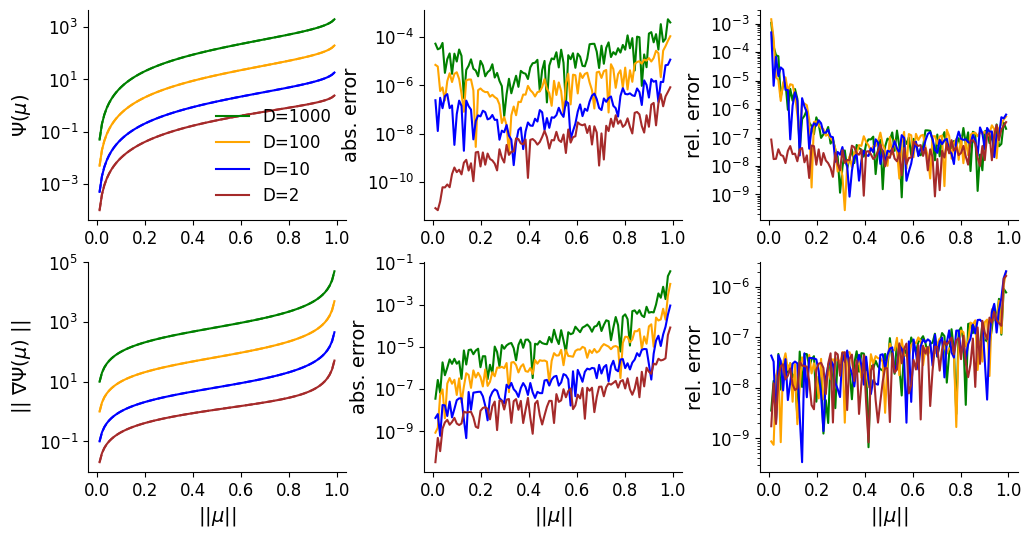

In [1]:
from vMFne.logpartition import gradΦ, invgradΦ, vMF_entropy_Φ, logχ, log_besseli, banerjee_44
from vMFne.negentropy import Ψ, Ψ_base, gradΨ, dΨ_base
from scipy.special import loggamma
import mpmath

import numpy as np
import matplotlib.pyplot as plt

Ds = [2, 10, 100, 1000][::-1] # reverse order for plotting reasons only

# Numerical ODE solver
Ψ0 = [0., 1e-6] # initial values for Ψ(0), Ψ'(0). Ψ(0) not that important, can be changed post-hoc.
t0 = 0.0        # starting point ||μ||=t0 for numerical integration. Should stay zero here !

# Newton-Raphson parameters
max_iter = 10
atol = 1e-12

# plotting
fontsize = 14
ticksize = 12
clrs = ['brown', 'b', 'orange', 'g'][::-1]
fig = plt.figure(figsize=(12, 6))
K = 100 # number of evaluation points ||μ[k]||, k=1,..,K between (exluding) 0 and (excluding) 1.
        # Note that these are forced checkpoints for the solver, the solver may use way more steps !

for i,D in enumerate(Ds):

    V = np.ones((K,D))/np.sqrt(D) # unit length vectors, some functions need vector-valued inputs

    μs_norm = np.linspace(0, 1, K+2)[1:-1]
    _, gradΨμ = Ψ(μs_norm.reshape(-1,1)*V, D, Ψ0=Ψ0, t0=t0, return_grad=True)

    κs = np.linalg.norm(gradΨμ,axis=-1)

    # re-compute ||μ|| = Φ'(||η||) to make sure H[η] is not at a disadvantage because η are bad
    # - if anything, μ are bad ! 
    μs_norm = np.linalg.norm(gradΦ(κs.reshape(-1,1)*V),axis=-1)
    Ψμ, gradΨμ = Ψ(μs_norm.reshape(-1,1)*V, D, Ψ0=Ψ0, t0=t0, return_grad=True, solve_delta=True)
    κs_est_0, diffs = invgradΦ(μs_norm,D,max_iter=0,atol=atol)
    κs_est, diffs = invgradΦ(μs_norm,D,max_iter=max_iter,atol=atol)

    # NegEntropy
    plt.subplot(2,3,1)
    H = vMF_entropy_Φ(κs_est.reshape(-1,1) * V)
    Ψμ0 = (D/2. - 1.) * np.log(2) + loggamma(D/2)
    negH = - H - logχ(D) - Ψμ0
    plt.semilogy(μs_norm, negH, '-', label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, Ψμ, '--', color=clrs[i])
    plt.ylabel(r'$\Psi(\mu)$', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)
    plt.legend(loc=4, fontsize=ticksize, frameon=False)

    # Gradient of NegEntropy
    plt.subplot(2,3,4)
    plt.semilogy(μs_norm, np.linalg.norm(gradΨμ,axis=-1), label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, κs_est, '--', color=clrs[i])
    plt.ylabel(r'$||\ \nabla\Psi(\mu)\ ||$', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)
    plt.xlabel(r'$||\mu||$', fontsize=fontsize)

    # error on Negentropy
    plt.subplot(2,3,2)    
    plt.semilogy(μs_norm, np.abs(negH - Ψμ), label='D='+str(D), color=clrs[i])
    plt.ylabel('abs. error', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    # error on gradients
    plt.subplot(2,3,5)    
    plt.semilogy(μs_norm, np.abs(np.linalg.norm(gradΨμ,axis=-1) - κs_est), '-',
                 label='D='+str(D), color=clrs[i])
    plt.ylabel('abs. error', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)
    plt.xlabel(r'$||\mu||$', fontsize=fontsize)

    # error on Negentropy
    plt.subplot(2,3,3)
    plt.semilogy(μs_norm, np.abs(negH - Ψμ)/negH, label='D='+str(D), color=clrs[i])
    plt.ylabel('rel. error', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    # error on gradients
    plt.subplot(2,3,6)    
    plt.semilogy(μs_norm, np.abs(np.linalg.norm(gradΨμ,axis=-1) - κs_est)/κs_est, '-',
                 label='D='+str(D), color=clrs[i])
    plt.xlabel(r'$||\mu||$', fontsize=fontsize)
    plt.ylabel('rel. error', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.spines[['right', 'top']].set_visible(False)

plt.subplots_adjust(wspace=0.3)
plt.savefig('fig1.pdf', bbox_inches='tight')
plt.show()


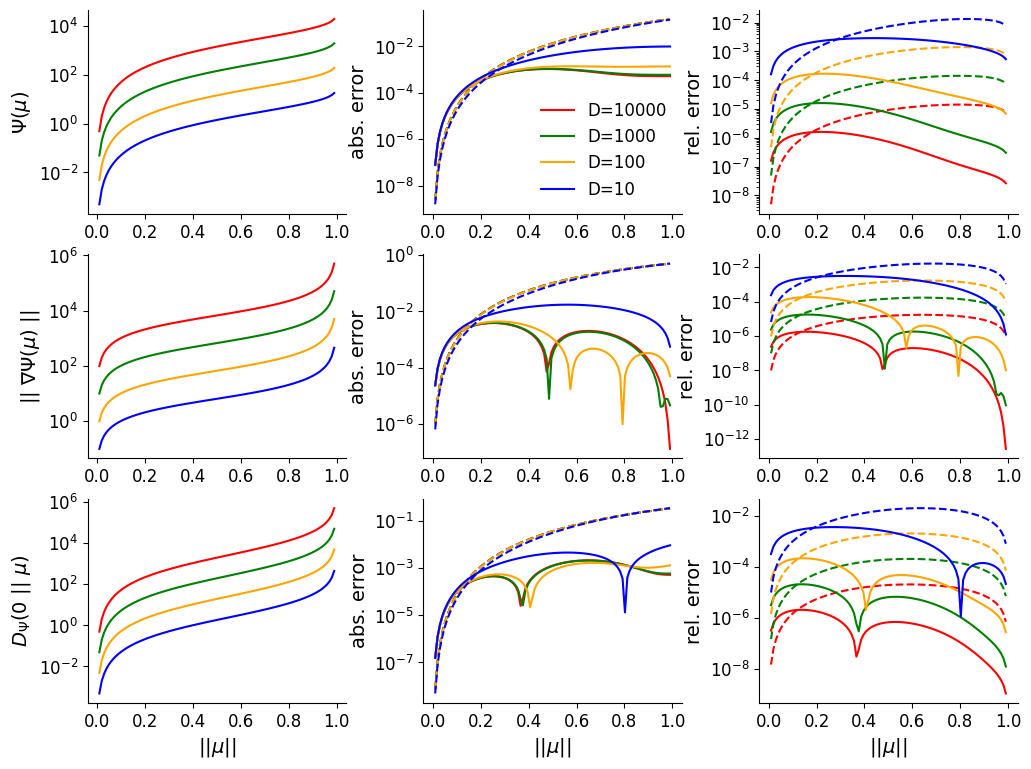

In [2]:
from vMFne.logpartition import gradΦ, invgradΦ, vMF_entropy_Φ, logχ, log_besseli, banerjee_44
from vMFne.negentropy import Ψ, Ψ_base, gradΨ, dΨ_base
from scipy.special import loggamma
import mpmath

import numpy as np
import matplotlib.pyplot as plt

Ds = [10, 100, 1000, 10000][::-1] # reverse order for plotting reasons only

# Numerical ODE solver
t0 = 0.0
Ψ0 = [0., 1e-5] # we're going to higher D's in this plot, so we increase Ψ'(0) to avoid underflows.

# plotting
clrs = ['b', 'orange', 'g', 'r'][::-1]
fontsize=14
ticksize=12
fig = plt.figure(figsize=(12, 9))
K = 100 # number of evaluation points ||μ[k]||, k=1,..,K between (exluding) 0 and (excluding) 1.

for i,D in enumerate(Ds):

    V = np.ones((K,D))/np.sqrt(D) # unit length vectors, some functions need vector-valued inputs
    μs_norm = np.linspace(0, 1, K+2)[1:-1]
    Ψμ, gradΨμ = Ψ(μs_norm.reshape(-1,1)*V, D, Ψ0=Ψ0, t0=t0, return_grad=True, solve_delta=True)

    # NegEntropy
    plt.subplot(3,3,1)
    plt.semilogy(μs_norm, Ψμ, label='D='+str(D), color=clrs[i])
    plt.ylabel(r'$\Psi(\mu)$', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    μ2 = μs_norm**2
    Ψμ44 = 0.5 *((1-D) * np.log(1 - μ2) + μ2)    

    # absolute error
    plt.subplot(3,3,2)
    plt.semilogy(μs_norm, np.abs(Ψμ - Ψ_base(μs_norm,D=D)), label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, np.abs(Ψμ - Ψμ44), '--', color=clrs[i])
    plt.ylabel(r'abs. error', fontsize=fontsize) # $(\Psi(\mu)- \tilde{\Psi}(\mu))/\Psi(\mu)$')
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)
    plt.legend(loc=4, fontsize=ticksize, frameon=False)

    # relative error
    plt.subplot(3,3,3)
    plt.semilogy(μs_norm, np.abs(Ψμ - Ψ_base(μs_norm,D=D)) / Ψμ, label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, np.abs(Ψμ - Ψμ44) / Ψμ, '--', color=clrs[i])
    plt.ylabel(r'rel. error', fontsize=fontsize) # $(\Psi(\mu)- \tilde{\Psi}(\mu))/\Psi(\mu)$')
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    # Gradient of NegEntropy
    plt.subplot(3,3,4)
    plt.semilogy(μs_norm, np.linalg.norm(gradΨμ,axis=-1), label='D='+str(D), color=clrs[i])
    plt.ylabel(r'$||\ \nabla\Psi(\mu)\ ||$', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    # absolute error
    plt.subplot(3,3,5)
    plt.semilogy(μs_norm, np.abs(np.linalg.norm(gradΨμ,axis=-1) - dΨ_base(μs_norm,D=D)),
                 label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, np.abs(np.linalg.norm(gradΨμ,axis=-1) - banerjee_44(μs_norm,D=D)),
                '--', color=clrs[i])
    plt.ylabel(r'abs. error', fontsize=fontsize) 
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    # relative error
    plt.subplot(3,3,6)
    plt.semilogy(μs_norm, 
                 np.abs(np.linalg.norm(gradΨμ,axis=-1)-dΨ_base(μs_norm,D=D))/np.linalg.norm(gradΨμ,axis=-1),
                 label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, 
                 np.abs(np.linalg.norm(gradΨμ,axis=-1)-banerjee_44(μs_norm,D=D))/np.linalg.norm(gradΨμ,axis=-1),
                '--', color=clrs[i])
    plt.ylabel(r'rel. error', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    # Bregman div + const
    plt.subplot(3,3,7)
    dΨdμ_x_μ = μs_norm * np.linalg.norm(gradΨμ,axis=1) - Ψμ
    plt.semilogy(μs_norm, dΨdμ_x_μ, label='D='+str(D), color=clrs[i])
    plt.ylabel(r'$D_\Psi(0\ ||\ \mu)$', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)
    plt.xlabel(r'$||\mu||$', fontsize=fontsize)

    dΨdμ_x_μ_base = μs_norm * dΨ_base(μs_norm,D=D) - Ψ_base(μs_norm,D=D)
    μ2 = μs_norm**2
    Ψμ44 = 0.5 *((1-D) * np.log(1 - μ2) + μ2)
    dΨdμ_x_μ_44 = μs_norm * banerjee_44(μs_norm,D=D) - Ψμ44

    # absolute error
    plt.subplot(3,3,8)
    plt.semilogy(μs_norm, np.abs(dΨdμ_x_μ - dΨdμ_x_μ_base), label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, np.abs(dΨdμ_x_μ - dΨdμ_x_μ_44) , '--', color=clrs[i])
    plt.ylabel(r'abs. error', fontsize=fontsize)
    plt.xlabel(r'$||\mu||$', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)

    # relative error
    plt.subplot(3,3,9)
    plt.semilogy(μs_norm, np.abs(dΨdμ_x_μ - dΨdμ_x_μ_base) / dΨdμ_x_μ, label='D='+str(D), color=clrs[i])
    plt.semilogy(μs_norm, np.abs(dΨdμ_x_μ - dΨdμ_x_μ_44) / dΨdμ_x_μ, '--', color=clrs[i])
    plt.ylabel(r'rel. error', fontsize=fontsize)
    plt.xlabel(r'$||\mu||$', fontsize=fontsize)
    plt.yticks(fontsize=ticksize)
    plt.xticks(fontsize=ticksize)


"""
# closed-form approximations to those values - leaving out since one can't see any difference anyways !
for i,D in enumerate(Ds):
    dΨdμ_x_μ_base = μs_norm * dΨ_base(μs_norm,D=D) - Ψ_base(μs_norm,D=D)
    μ2 = μs_norm**2
    Ψμ44 = 0.5 *((1-D) * np.log(1 - μ2) + μ2)
    dΨdμ_x_μ_44 = μs_norm * banerjee_44(μs_norm,D=D) - Ψμ44

    plt.subplot(2,3,1)
    plt.plot(μs_norm, Ψ_base(μs_norm,D=D), ':', color='k')
    μ2 = μs_norm**2
    Ψμ44 = 0.5 *((1-D) * np.log(1 - μ2) + μ2)    
    plt.plot(μs_norm, Ψμ44, '--', color='gray')
    plt.subplot(2,3,2)
    plt.plot(μs_norm, dΨ_base(μs_norm,D=D), ':', color='k')
    plt.plot(μs_norm, banerjee_44(μs_norm,D=D), '--', color='gray')
    plt.subplot(2,3,3)
    plt.plot(μs_norm, dΨdμ_x_μ_base, ':', color='k')
    plt.plot(μs_norm, dΨdμ_x_μ_44, '--', color='gray')
"""

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.spines[['right', 'top']].set_visible(False)

plt.subplots_adjust(wspace=0.3) # more space horizontally between panels
plt.savefig('fig2.pdf', bbox_inches='tight')
plt.show()


# On the initial condition
 - $\psi'(0) = 0$ means that $\psi''(0) = \frac{0}{0}$ is ill-defined.
 - in practice we start from 'something small', but not small enough to underflow with given numerical precision (64-bit)
 - typically, $\psi'(0) = 1e-6$ for $D < 100$, $\psi'(0) = 1e-4$ for $D\geq 1000$. With much larger $D$, might have to go even smaller
 - here we look at $D=2$ and $D=100$ to show that solutions quickly approach each other, i.e. error from $\psi'(0) > 0$ is mostly limited to small $||\mu||$.
 
 

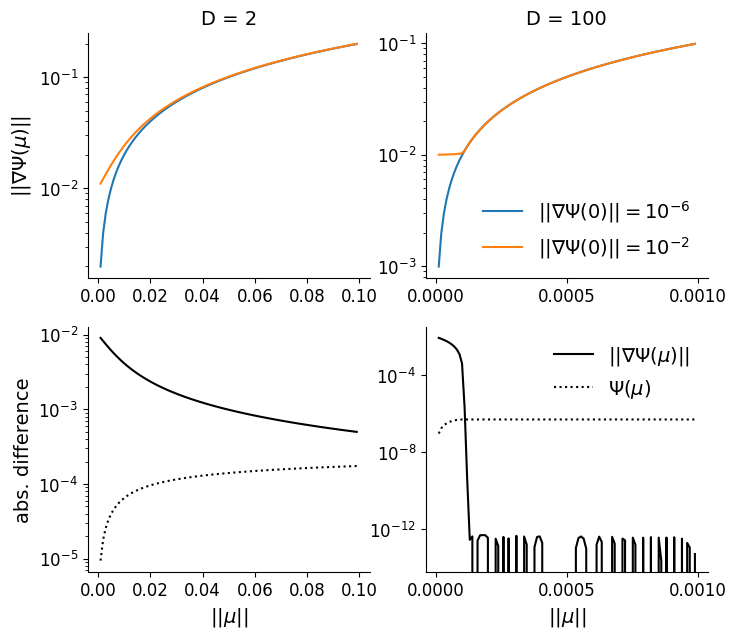

In [3]:
from vMFne.logpartition import gradΦ, invgradΦ, vMF_entropy_Φ, logχ, log_besseli, banerjee_44
from vMFne.negentropy import Ψ, Ψ_base, gradΨ, dΨ_base
from scipy.special import loggamma
import mpmath

import numpy as np
import matplotlib.pyplot as plt


dΨ0 = [1e-6, 1e-2] # values to try for Ψ'(0).

t0 = 0.0 # start numerical integration from ||μ||=t0.
K = 100  # number of evaluation points between 0 and max{||μ||} for this experiment.

D = 2
V = np.ones((K,D))/np.sqrt(D) # unit length vectors, some functions need vector-valued inputs

Ψμs = np.zeros((len(dΨ0), K))
dΨμs = np.zeros((len(dΨ0), K))
μs_norm = np.linspace(0, 0.1, K+2)[1:-1]
for i in range(len(dΨ0)):
    Ψ0 = [0., dΨ0[i]]
    Ψμ, dΨμ = Ψ(μs_norm.reshape(-1,1)*V, D, Ψ0=Ψ0, t0=t0, return_grad=True)
    Ψμs[i] = Ψμ
    dΨμs[i] = np.linalg.norm(dΨμ,axis=-1)

fontsize=14
ticksize=12

plt.figure(figsize=(8,7))
    
plt.subplot(2,2,1)
plt.semilogy(μs_norm, dΨμs.T)
plt.ylabel(r"$|| \nabla\Psi(\mu) ||$",fontsize=fontsize)
plt.title('D = 2',fontsize=fontsize)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

plt.subplot(2,2,3)
plt.semilogy(μs_norm, np.diff(Ψμs,axis=0).T, 'k:')
plt.semilogy(μs_norm, np.diff(dΨμs,axis=0).T, 'k') 
plt.xlabel(r"$|| \mu ||$",fontsize=fontsize)
plt.ylabel("abs. difference",fontsize=fontsize)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)


D = 100
V = np.ones((K,D))/np.sqrt(D)

Ψμs = np.zeros((len(dΨ0), K))
dΨμs = np.zeros((len(dΨ0), K))
μs_norm = np.linspace(0, 0.001, K+2)[1:-1]
for i in range(len(dΨ0)):
    Ψ0 = [0., dΨ0[i]]
    Ψμ, dΨμ = Ψ(μs_norm.reshape(-1,1)*V, D, Ψ0=Ψ0, t0=t0, return_grad=True)
    Ψμs[i] = Ψμ
    dΨμs[i] = np.linalg.norm(dΨμ,axis=-1)

plt.subplot(2,2,2)
plt.semilogy(μs_norm, dΨμs.T)
plt.legend([r"$||\nabla\Psi(0)||=10^{-6}$", r"$||\nabla\Psi(0)||=10^{-2}$"], frameon=False,fontsize=fontsize)
plt.title('D = 100',fontsize=fontsize)
plt.yticks(fontsize=ticksize)
plt.xticks([0, 0.0005, 0.001], fontsize=ticksize)

plt.subplot(2,2,4)
plt.semilogy(μs_norm, np.diff(dΨμs,axis=0).T, 'k') 
plt.semilogy(μs_norm, np.diff(Ψμs,axis=0).T, 'k:')
plt.legend([r"$||\nabla\Psi(\mu)||$", r"$\Psi(\mu)$"], frameon=False,fontsize=fontsize)
plt.xlabel(r"$|| \mu ||$",fontsize=fontsize)
plt.yticks([1e-4, 1e-8, 1e-12], fontsize=ticksize)
plt.xticks([0, 0.0005, 0.001], fontsize=ticksize)

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.spines[['right', 'top']].set_visible(False)

plt.savefig('figS1.pdf', bbox_inches='tight')
plt.show()


# Data application - Bregman clustering

- we want to showacse the use of the negative entropy and its gradient for the mean-parameter representation of the von-Mises Fisher distribiution
- to this end, we reproduce previous work (Banerjee et al. 2005) on document clustering in high-dimensional spherical feature spaces.
- this line of work uses mixtures of von-Mises Fisher ('movMF') distributions to infer latent cluster assignments for individual documents mapped onto a spherical feature space. 
- we compare the classical movFM algorithm (in natural-parameter space) against Bregman Clustering (in mean-parameter space), and do this over two different variants of movFM models (tied and independent variances across mixture components). 
- datasets are the classic datasets ['20-newsgroups'](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) and ['classic3'](http://ir.dcs.gla.ac.uk/resources/test_collections/), as well as subsampled variants thereof. 


## run all algorithms for spherical clustering on both datasets

In [ ]:
import os
if not os.path.exists('results'):
    os.makedirs('results')

In [ ]:
# The information retrieval (IR) group at the School of Computing Science of the University of Glasgow 
# hosts a copy of the classic3 dataset which we retrieve using the wget package.

import wget
import tarfile 

wget.download('http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/cisi.tar.gz', 'data/cisi.tar.gz')
wget.download('http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz', 'data/cran.tar.gz')
wget.download('http://ir.dcs.gla.ac.uk/resources/test_collections/medl/med.tar.gz', 'data/med.tar.gz')

fns = ['cisi.tar.gz', 'cran.tar.gz', 'med.tar.gz']
names = ['CISI.ALL', 'cran.all.1400', 'MED.ALL']
for fn, name in zip(fns, names):
    file = tarfile.open('data/' + fn) 
    file.extract(name, 'data/') 
    file.close() 

In [ ]:
from exps import run_all_classic3

version = '0'
classic300 = True

run_all_classic3(fn_root='results/classic300_', n_repets=10, K_range=[2,3,4,5,6,7,8,9,10,11], 
                 seed=0, max_iter=100, κ_max=10000., Ψ0=[None, 0.], version=version, 
                 classic300=classic300, verbose=True, min_df=2, max_df=0.15)


In [ ]:
from exps import run_all_classic3

version = '0'
classic300 = False

run_all_classic3(fn_root='results/classic3_', n_repets=10, K_range=[2,3,4,5,6,7,8,9,10,11], 
                 seed=0, max_iter=100, κ_max=10000., Ψ0=[None, 0.], version=version, 
                 classic300=classic300, verbose=True)


In [ ]:
from exps import run_all_news20

version = '0'
news20_small = True

run_all_news20(fn_root='results/news20small_', n_repets=10, K_range=[4,8,12,16,20,24,28,32,36,40], 
                 seed=0, max_iter=100, κ_max=10000., Ψ0=[None, 0.], version=version, 
                 news20_small=news20_small, verbose=True, min_df=2, max_df=0.15)


In [ ]:
from exps import run_all_news20

version = '0'
news20_small = False

run_all_news20(fn_root='results/news20_', n_repets=10, K_range=[4,8,12,16,20,24,28,32,36,40], 
                 seed=0, max_iter=100, κ_max=10000., Ψ0=[None, 0.], version=version, 
                 news20_small=news20_small, verbose=True)


# Bregman clustering contd'
## compute & store (normalized) mutual information across all algorithms and datasets
- needs previous cells to run first.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

from exps import load_classic3_sklearn, load_news20_sklearn
from vMFne.bregman_clustering import posterior_marginal_vMF_mixture_Ψ
from vMFne.moVMF import posterior_marginal_vMF_mixture_Φ

Ψ0 = [None, 0.]

# Calculate MI between two clusterings
def mi(class_true, class_est):
    cont = metrics.cluster.contingency_matrix(class_true, class_est, sparse=True).astype(np.float64, copy=False)
    mi = metrics.cluster.mutual_info_score(class_true, class_est, contingency=cont)
    return mi

def get_MIs(fn_rootroot, fn_roots, n_repets, K_range, class_true, NMI=False):
    MIs = np.zeros((len(fn_roots), n_repets, len(K_range)))
    comp_mi = metrics.normalized_mutual_info_score if NMI else mi
    for f,fn_root in enumerate(fn_roots):
        for k,K in enumerate(K_range):
            if f == 0:
                fn = fn_rootroot + fn_root + str(K) + '.npy'
                out = np.load(fn, allow_pickle=True)
                for i in range(n_repets):
                    class_est = out[i]
                    MIs[f,i,k] =  comp_mi(class_true.flatten(), class_est.flatten())
            elif f in [1,2,5,6]:
                fn = fn_rootroot + fn_root + str(K) + '.npz'
                out = np.load(fn, allow_pickle=True)['out'].tolist()
                for i in range(n_repets):
                    ph_x_μ, _ = posterior_marginal_vMF_mixture_Ψ(X,out['w'][i],out['μs'][i], Ψ0=Ψ0)
                    class_est = np.argmax(ph_x_μ,axis=1)
                    MIs[f,i,k] = comp_mi(class_true.flatten(), class_est.flatten()) 
            elif f in [3,4,7,8]:
                fn = fn_rootroot + fn_root + str(K) + '.npz'
                out = np.load(fn, allow_pickle=True)['out'].tolist()
                for i in range(n_repets):
                    ph_x_η, _ = posterior_marginal_vMF_mixture_Φ(X,out['w'][i],out['ηs'][i])
                    class_est = np.argmax(ph_x_η,axis=1)
                    MIs[f,i,k] = comp_mi(class_true.flatten(), class_est.flatten()) 
    return MIs

def get_fn_roots(n_repets, version):
    return [f'spkmeans_{n_repets}repets_seed_0_v{version}__K_',
            f'softBregClust_{n_repets}repets_seed_0_no_tying__v{version}__K_',
            f'softBregClust_{n_repets}repets_seed_0_with_tying__v{version}__K_',
            f'softmovMF_{n_repets}repets_seed_0_no_tying__v{version}__K_',
            f'softmovMF_{n_repets}repets_seed_0_with_tying__v{version}__K_',
            f'hardBregClust_{n_repets}repets_seed_0_no_tying__v{version}__K_',
            f'hardBregClust_{n_repets}repets_seed_0_with_tying__v{version}__K_',
            f'hardmovMF_{n_repets}repets_seed_0_no_tying__v{version}__K_',
            f'hardmovMF_{n_repets}repets_seed_0_with_tying__v{version}__K_']


In [ ]:
fn_rootroot = 'results/classic3_'
K_range = np.arange(2,12,1)
n_repets = 10
version = 0
seed = 0

X, labels, dictionary = load_classic3_sklearn()
class_true = sum([ (1.*i) * (labels==np.unique(labels)[i]) for i in range(len(np.unique(labels)))])

fn_roots = get_fn_roots(n_repets, version)
MIs_classic3 = get_MIs(fn_rootroot, fn_roots, n_repets, K_range, class_true, NMI=False)

np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', MIs_classic3)
np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', 
        {'MIs' : MIs_classic3,
         'algorithms' : fn_roots,
         'K_range' : K_range,
         'seed' : seed,
         'n_repets' : n_repets,
        })


In [ ]:
fn_rootroot = 'results/classic300_'
K_range = np.arange(2,12,1)
n_repets = 10
version = 0
seed = 0

X, labels, dictionary = load_classic3_sklearn(classic300=True, min_df=2, max_df=0.15)
class_true = sum([ (1.*i) * (labels==np.unique(labels)[i]) for i in range(len(np.unique(labels)))])

fn_roots = get_fn_roots(n_repets, version)
MIs_classic300 = get_MIs(fn_rootroot, fn_roots, n_repets, K_range, class_true, NMI=False)

np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', MIs_classic300)
np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', 
        {'MIs' : MIs_classic300,
         'algorithms' : fn_roots,
         'K_range' : K_range,
         'seed' : seed,
         'n_repets' : n_repets,
        })


In [ ]:
fn_rootroot = 'results/news20_'
K_range = np.arange(4,41,4)
n_repets = 10
version = 0
seed = 0

X, labels, dictionary = load_news20_sklearn()
class_true = sum([ (1.*i) * (labels==np.unique(labels)[i]) for i in range(len(np.unique(labels)))])

fn_roots = get_fn_roots(n_repets, version)
MIs_news20 = get_MIs(fn_rootroot, fn_roots, n_repets, K_range, class_true, NMI=False)

np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', MIs_news20)
np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', 
        {'MIs' : MIs_news20,
         'algorithms' : fn_roots,
         'K_range' : K_range,
         'seed' : seed,
         'n_repets' : n_repets,
        })


In [ ]:
fn_rootroot = 'results/news20small_'
K_range = np.arange(4,41,4)
n_repets = 10
version = 0
seed = 0
X, labels, dictionary = load_news20_sklearn(news20_small=True, min_df=2, max_df=0.15)
class_true = sum([ (1.*i) * (labels==np.unique(labels)[i]) for i in range(len(np.unique(labels)))])

fn_roots = get_fn_roots(n_repets, version)
MIs_news20small = get_MIs(fn_rootroot, fn_roots, n_repets, K_range, class_true, NMI=False)

np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', MIs_news20small)
np.save(f'{fn_rootroot}MIs_{n_repets}repets_seed_0_v{version}__K{min(K_range)}_{max(K_range)}', 
        {'MIs' : MIs_news20small,
         'algorithms' : fn_roots,
         'K_range' : K_range,
         'seed' : seed,
         'n_repets' : n_repets,
        })


# Bregman clustering contd'
## make results figure
We included our final results for a quick reconstruction of the data application figure (Fig 3) of the manuscript. 
If you already ran the above code cells, they will have already been overwritten by the results from the movMF fits.
These results include:
- Normalized Mutual Information scores between true and estimates clustering for 9 different algorithmic variants for fitting mixtures of vMF distributions to the document clustering data:
  
  0 : Spherical K-means (not shown in document)
  
  1 : soft Bregman clustering for full EM on full movFM model
  
  2 : soft Bregman clustering for full EM on restricted movFM model (tied variances)
  
  3 : soft movFM EM for full EM on full movFM model
  
  4 : soft movFM EM for full EM on restricted movFM model (tied variances)
  
  5 : hard Bregman clustering for hard-assigment EM on full movFM model
  
  6 : hard Bregman clustering for hard-assigment EM on restricted movFM model (tied variances)
  
  7 : hard movFM EM for full EM on full movFM model
  
  8 : hard movFM EM for full EM on restricted movFM model (tied variances)

- all of the above for for $10$ different random seeds and $10$ different numbers of clusters.
- all of the above for 4 different datasets: news20, classic3, news20-small, classic300.

e.g. 'results/news20_NMIs_10repets_seed_0_v0__K4_40.npy' contains a 9x10x10 matrix of normalized mutual information scores for algorithms 0-8 on 10 different random seeds and 10 different numbers of clusters (in this case, $K=4,8,\ldots,40$)

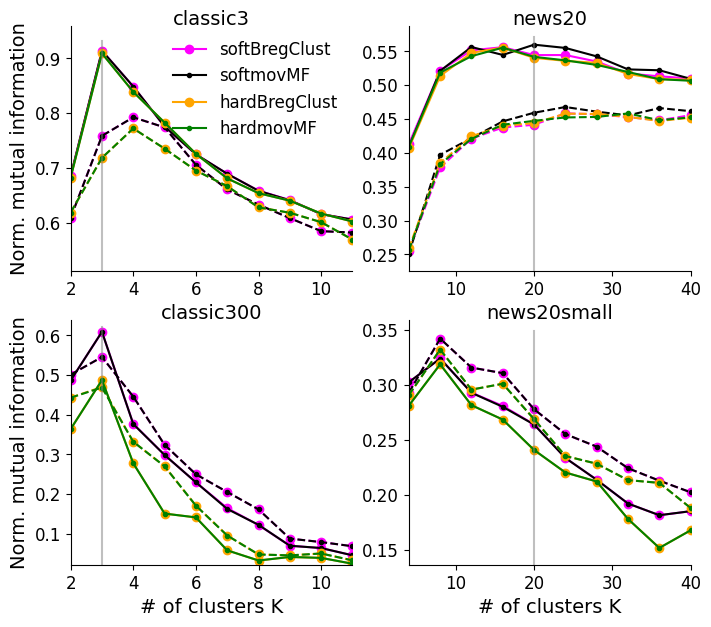

In [4]:
import numpy as np
import matplotlib.pyplot as plt

alg_names = ['spkmeans',
             'softBregClust',
             'softBregClust',
             'softmovMF',
             'softmovMF',
             'hardBregClust',
             'hardBregClust',
             'hardmovMF',
             'hardmovMF']

Kminmax= [[2,11], [4,40]]
true_Ks = [3, 20]

n_repets = 10
version = 0
seed = 0

clrs = ['b', 'magenta', 'magenta', 'black', 'black', 'orange', 'orange', 'green', 'green' ]
lnstl = ['-', '--', '-', '--', '-', '--', '-', '--', '-']
mrkrs = ['.','o','o','.','.','o','o','.','.']

fontsize=14
ticksize=12

fn_rootroots = [['results/classic3_', 'results/classic300_'],
                ['results/news20_', 'results/news20small_']]

plt.figure(figsize=(8,7))
for j in range(len(fn_rootroots)): # over datasets 

    for i, fn_rootroot in enumerate(fn_rootroots[j]): # over algorithms

        plt.subplot(2,2,2*i + j + 1)
        out = dict(np.load(
            f'{fn_rootroot}NMIs_{n_repets}repets_seed_0_v{version}__K{Kminmax[j][0]}_{Kminmax[j][1]}.npy',
            allow_pickle=True).tolist())

        for f in range(len(alg_names)):
            if alg_names[f] == 'spkmeans':
                pass
            elif lnstl[f] == '-':
                plt.plot(out['K_range'], out['MIs'].mean(axis=1)[f], label=alg_names[f], 
                         color=clrs[f], linestyle=lnstl[f], marker=mrkrs[f])
            else:
                plt.plot(out['K_range'], out['MIs'].mean(axis=1)[f], 
                         color=clrs[f], linestyle=lnstl[f], marker=mrkrs[f])
        plt.title(fn_rootroot[8:-1], fontsize=fontsize, y=0.97)
        plt.xlim([Kminmax[j][0], Kminmax[j][1]])
        plt.plot([true_Ks[j], true_Ks[j]], [0.9*out['MIs'].mean(axis=1).min(), 1.02*out['MIs'].mean(axis=1).max()],
                 color='gray', alpha=0.5)
        plt.ylim([0.9*out['MIs'].mean(axis=1).min(), 1.05*out['MIs'].mean(axis=1).max()])
        plt.yticks(fontsize=ticksize)
        plt.xticks(fontsize=ticksize)
        if i == 0 and j == 0:
            plt.legend(fontsize=ticksize, frameon=False)
        if j == 0:
            plt.ylabel('Norm. mutual information', fontsize=fontsize)
        if i == 1:
            plt.xlabel('# of clusters K', fontsize=fontsize)

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.spines[['right', 'top']].set_visible(False)

plt.savefig('fig3.pdf', bbox_inches='tight')
plt.show()
